In [1]:
import os
import cv2
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt 

from skimage.color import rgb2gray, label2rgb
from skimage.measure import label as sk_measure_label
from skimage.measure import regionprops



In [2]:
from intelligent_placer_lib import recognizer as ip


### Вторая итерация. Демонстрация текущей реализации


### Предобработка

Шаг 1. Выбор изображения для иллюстрации работы алгоритма

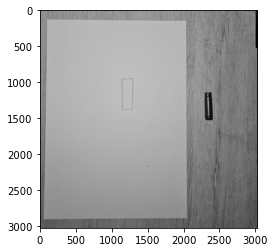

In [3]:
image_file = os.path.join("data", "examples", f'{1}', 'in.jpg')

image_as_gray = rgb2gray(cv2.imread(image_file))
plt.imshow(image_as_gray, cmap='gray')

Шаг2. Получение бинарной маски для всего изображения

На этом этапе в маске видны дефекты, их устранение - в последующих функциях 

* *Возможное улучшение : [restoration.rolling_ball для удаления фона](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rolling_ball.html?highlight=restoration%20rolling_ball)



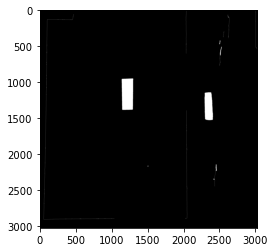

In [4]:
mask = ip.get_mask_of_total_image(image_as_gray)

plt.imshow(mask, cmap='gray')

Шаг3. Получим лист областей связности и значение из площадей


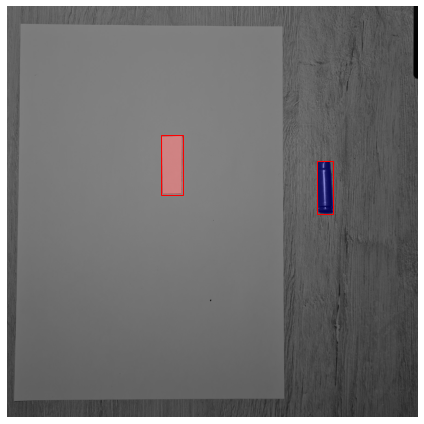

In [5]:
labels = ip.get_component_and_areas(mask)


image_label_overlay = label2rgb(labels, image=image_as_gray, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
for region in regionprops(labels):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
ax.set_axis_off()
plt.tight_layout()
plt.show()


Шаг4. Ищем многоугольник с помощью get_polygon_region как самую левую область и убираем его из листа компонент. Оставшиея компоненты - объекты

Найден многоугольник, его площадь = 66584


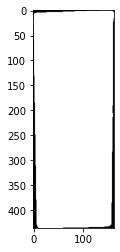

In [6]:
polygon_region = ip.get_polygon_region(labels)
plt.imshow(polygon_region.image, cmap='gray')
print(f"Найден многоугольник, его площадь = {polygon_region.area}")


Найден объект, его площадь = 40075


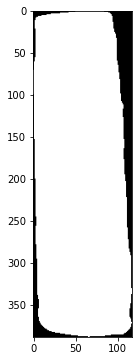

In [12]:
object_regions = ip.get_objects_regions(labels,polygon_region)
fig, ax = plt.subplots(1,len(object_regions), figsize=(15, 6))

for ind, regs in enumerate(object_regions):
    print(f"Найден объект, его площадь = {regs.area}")
    if len(object_regions) == 1:
        plt.imshow(regs.image, cmap='gray')
    else:
        ax[ind].imshow(regs.image, cmap='gray')



### Расположение

Проверим крайние случаи невозможности расположить объекты.
* Проверка на то, меньше ли сумма площадей объектов площади многоугольника
* Проверка на то, что наибольшая длина описывающего эллипса для каждого предмета меньше наиб. длины описывающего эллипса многоугольника

In [ ]:
ip.is_total_object_area_smaller_than_polygon_area(polygon_region, object_regions)

True

In [ ]:
ip.is_all_objects_major_lenghs_fit_polygon(polygon_region, object_regions)

True

Сам алгоритм - перебор

Подробнее - в плане (в последующем будет обновлен) и в recognizer.py

In [11]:
res, img = ip.not_very_intelligent_but_placer(object_regions, polygon_region)
print(res)

True


Возможно все таки добавится сравнение с эталонными масками для гарантии того, что крупные дефекты фона не будут распознаны как объекты

In [15]:
from skimage.io import imread_collection
dirName = 'data/objects/*'
collection = imread_collection(dirName)





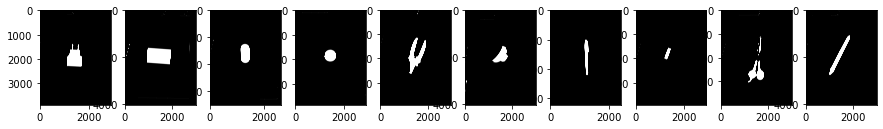

In [16]:
fig, ax = plt.subplots(1,len(collection), figsize=(15, 6))
Binary_object_mask_list = []
for i,bin_mask in enumerate(collection):
    bin_mask = rgb2gray(bin_mask)
    bin_mask = ip.get_mask_of_total_image(bin_mask)
    Binary_object_mask_list.append(bin_mask)
    ax[i].imshow(Binary_object_mask_list[i], cmap='gray')




In [17]:
for i,bin_mask in enumerate(Binary_object_mask_list):
    cv2.imwrite("data/masks/"+ str(i) +'.jpg',bin_mask*255)
    